# Extracting contour lines <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Acknowledgement**: This notebook was originally created by [Digital Earth Australia (DEA)](https://www.ga.gov.au/about/projects/geographic/digital-earth-australia) and has been modified for use in the EY Data Science Program

* **Products used:** 
External elevation data from [CGIAR - Consortium for Spatial Information (CGIAR-CSI)](http://srtm.csi.cgiar.org/srtmdata/)




## Background
[Contour extraction](https://en.wikipedia.org/wiki/Contour_line) is a fundamental image processing method used to detect and extract the boundaries of spatial features. 
While contour extraction has traditionally been used to precisely map lines of given elevation from digital elevation models (DEMs), contours can also be extracted from any other array-based data source. 
This can be used to support remote sensing applications where the position of a precise boundary needs to be mapped consistently over time, such as extracting dynamic waterline boundaries from satellite-derived Normalized Difference Water Index (NDWI) data.

## Description
This notebook demonstrates how to use the `subpixel_contours` function based on tools from `skimage.measure.find_contours` to:

1. Extract one or multiple contour lines from a single two-dimensional digital elevation model (DEM) and export these as a shapefile
2. Optionally include custom attributes in the extracted contour features
3. Load in a multi-dimensional satellite dataset from Digital Earth Australia, and extract a single contour value consistently through time along a specified dimension
4. Filter the resulting contours to remove small noisy features

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from affine import Affine
from datacube.utils.geometry import CRS

sys.path.append('../scripts')
from dea_datahandling import load_ard
from dea_datahandling import download_unzip
from dea_spatialtools import subpixel_contours
from dea_bandindices import calculate_indices


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Contour_extraction')


## Load elevation data
To demonstrate contour extraction, we first need to obtain an elevation dataset. 
Here we download a tile of 90 m (3 arc seconds) resolution Shuttle Radar Topography Mission (SRTM) Digital Elevation Model (DEM) data for a region that includes Canberra using the `download_unzip` function from `dea_datahandling`. 
This data comes from the [CGIAR - Consortium for Spatial Information (CGIAR-CSI)](http://srtm.csi.cgiar.org/srtmdata/).

After we download the data, we load it in `xarray.open_rasterio` and modify the projection system and geotransform attributes so it is consistent was data loaded from Digital Earth Australia.

In [3]:
help(download_unzip)

Help on function download_unzip in module dea_datahandling:

download_unzip(url, output_dir=None, remove_zip=True)
    Downloads and unzips a .zip file from an external URL to a local
    directory.
    
    Parameters
    ----------
    url : str
        A string giving a URL path to the zip file you wish to download
        and unzip
    output_dir : str, optional
        An optional string giving the directory to unzip files into.
        Defaults to None, which will unzip files in the current working
        directory
    remove_zip : bool, optional
        An optional boolean indicating whether to remove the downloaded
        .zip file after files are unzipped. Defaults to True, which will
        delete the .zip file.



In [4]:
path = "./outputs/Contour_extraction/"

# Download and unzip the elevation data
download_unzip(url='http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_66_20.zip', output_dir = path)

# Read in the elevation data from file
elevation_array = xr.open_rasterio(path + 'srtm_66_20.tif').squeeze('band')

# Modify CRS and transform attributes into a format that is
# consistent with data loaded from `dc.load`
elevation_array.attrs['crs'] = CRS(elevation_array.crs[-9:])
elevation_array.attrs['transform'] = Affine(*elevation_array.transform)

# Print the data
print(elevation_array)

Unzipping output files to: ./outputs/Contour_extraction/
<xarray.DataArray (y: 6000, x: 6000)>
[36000000 values with dtype=int16]
Coordinates:
    band     int64 1
  * y        (y) float64 -35.0 -35.0 -35.0 -35.0 ... -40.0 -40.0 -40.0 -40.0
  * x        (x) float64 145.0 145.0 145.0 145.0 ... 150.0 150.0 150.0 150.0
Attributes:
    transform:      | 0.00, 0.00, 145.00|\n| 0.00,-0.00,-35.00|\n| 0.00, 0.00...
    crs:            epsg:4326
    res:            (0.0008333333333333334, 0.0008333333333333334)
    is_tiled:       0
    nodatavals:     (-32768.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


We can plot a subset of the elevation data for a region around Canberra using a custom terrain-coloured colour map:

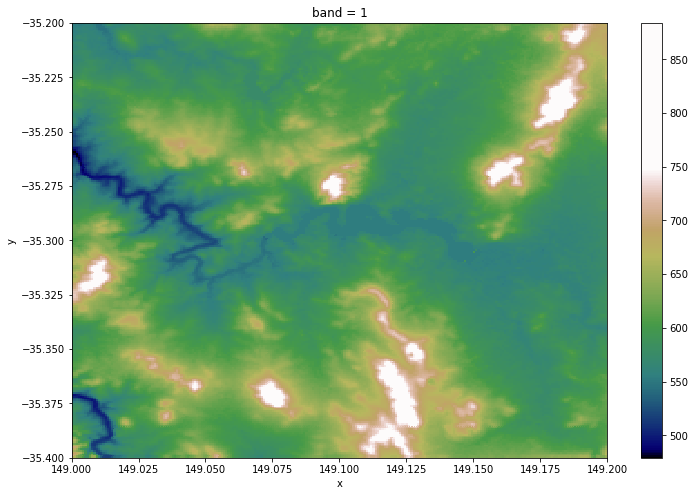

In [5]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.gist_earth(np.linspace(0.0, 1.5, 100))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('terrain', 
                                                            colors_terrain)

# Plot a subset of the elevation data
elevation_array.sel(x=slice(149.00, 149.20),
                    y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)


## Contour extraction in 'single array, multiple z-values' mode
The `dea_spatialtools.subpixel_contours` function uses `skimage.measure.find_contours` to extract contour lines from an array. 
This can be an elevation dataset like the data imported above, or any other two-dimensional or multi-dimensional array. 
We can extract contours from the elevation array imported above by providing a single z-value (e.g. elevation) or a list of z-values. 

### Extracting a single contour
Here, we extract a single 600 m elevation contour:

In [6]:
# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=600)

# Print output
contours_gdf

Operating in multiple z-value, single array mode


,z_value,geometry
0,600,"MULTILINESTRING ((148.03014 -35.00042, 148.029..."


This returns a `geopandas.GeoDataFrame` containing a single contour line feature with the z-value (i.e. elevation) given in a shapefile field named `z_value`. 
We can plot contour this for the Canberra subset:

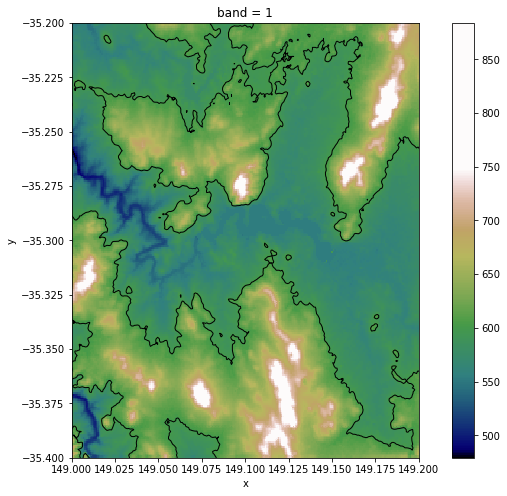

In [7]:
elevation_array.sel(x=slice(149.00, 149.20), 
                    y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  


### Extracting multiple contours 
We can easily import multiple contours from a single array by supplying a list of z-values to extract. 
The function will then extract a contour for each value in `z_values`, skipping any contour elevation that is not found in the array.


Operating in multiple z-value, single array mode


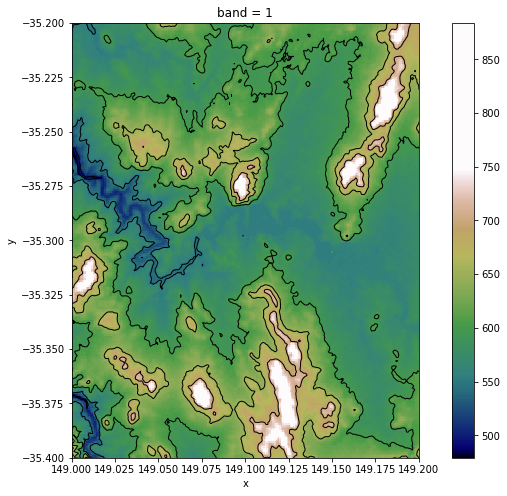

In [8]:
# List of elevations to extract
z_values = [500, 550, 600, 650, 700]

# Extract contours
contours_gdf = subpixel_contours(da=elevation_array,
                                 z_values=z_values)

# Plot extracted contours over the DEM
elevation_array.sel(x=slice(149.00, 149.20), 
                    y=slice(-35.20, -35.40)).plot(size=8, cmap=cmap_terrain)
contours_gdf.plot(ax=plt.gca(), linewidth=1.0, color='black')  

### Custom shapefile attributes
By default, the shapefile includes a single `z_value` attribute field with one feature per input value in `z_values`. 
We can instead pass custom attributes to the output shapefile using the `attribute_df` parameter. 
For example, we might want a custom column called `elev_cm` with heights in cm instead of m, and a `location` column giving the location (Australian Capital Territory or ACT). 

We can achieve this by first creating a `pandas.DataFrame` with column names giving the name of the attribute we want included with our contour features, and one row of values for each number in `z_values`:

In [9]:
# Elevation values to extract
z_values = [550, 600, 650]

# Set up attribute dataframe (one row per elevation value above)
attribute_df = pd.DataFrame({'elev_cm': [55000, 60000, 65000],
                             'location': ['ACT', 'ACT', 'ACT']})

# Print output
attribute_df.head()

,elev_cm,location
0,55000,ACT
1,60000,ACT
2,65000,ACT


We can now extract contours, and the resulting contour features will include the attributes we created above:

In [10]:
# Extract contours with custom attribute fields:
contours_gdf = subpixel_contours(da=elevation_array,                               
                                 z_values=z_values,
                                 attribute_df=attribute_df)

# Print output
contours_gdf.head()

Operating in multiple z-value, single array mode


,z_value,elev_cm,location,geometry
0,550,55000,ACT,"MULTILINESTRING ((148.04083 -35.00042, 148.040..."
1,600,60000,ACT,"MULTILINESTRING ((148.03014 -35.00042, 148.029..."
2,650,65000,ACT,"MULTILINESTRING ((148.03792 -35.00479, 148.037..."


### Exporting contours to file
To export the resulting contours to file, use the `output_path` parameter. 
The function supports two output file formats:

1. GeoJSON (.geojson)
2. Shapefile (.shp)


In [11]:
subpixel_contours(da=elevation_array,                               
                  z_values=z_values,
                  output_path=path + 'output_contours.geojson')

Operating in multiple z-value, single array mode
Writing contours to ./outputs/Contour_extraction/output_contours.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,z_value,geometry
0,550,"MULTILINESTRING ((148.04083 -35.00042, 148.040..."
1,600,"MULTILINESTRING ((148.03014 -35.00042, 148.029..."
2,650,"MULTILINESTRING ((148.03792 -35.00479, 148.037..."


***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please review the FAQ section and support options on the [EY Data Science platform](https://datascience.ey.com/).